In [1]:

# =============================================================================
# EXTRACCIÓN DE DATOS API CATAPULT - VERSIÓN MEJORADA CON LIMPIEZA INTEGRADA
# =============================================================================

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import json
from datetime import datetime, timedelta
import time
import numpy as np
import os
from pathlib import Path
import re
import unicodedata
import subprocess

In [4]:
def extraer_eventos_rugby_actividad(activity_id, athlete_id=None):
    """
    Función para extraer múltiples tipos de eventos de rugby para una actividad específica.
    Puede obtener eventos para todos los atletas de la actividad o solo para un atleta específico.
    
    Parámetros:
    - activity_id: ID de la actividad (obligatorio)
    - athlete_id: ID del atleta (opcional, si se proporciona se extraen eventos solo para ese atleta)
    
    Retorna:
    - DataFrame con los registros de eventos procesados para todos los atletas o el atleta específico
    """
    print(f"🔍 Extrayendo eventos de rugby para actividad: {activity_id}")
    if athlete_id:
        print(f"🏃 Filtrando para atleta específico: {athlete_id}")
    
    # Configuración básica
    BASE_URL = "https://connect-eu.catapultsports.com/api/v6"
    API_KEY = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
    
    # Headers con el token de autenticación
    headers = {
        'Authorization': f'Bearer {API_KEY}',
        'Content-Type': 'application/json'
    }
    
    # Campos específicos que queremos extraer
    campos_especificos = [
        "confidence",
        "duration",
        "active_percentage",
        "post_event_load",
        "post_event_active", 
        "post_event_back_in_game_time"
    ]
    
    # Definir los tipos de eventos a extraer con sus etiquetas
    tipos_eventos = {
        "rugby_union_contact_involvement": "Contact",
        "rugby_union_kick": "Kick",
        "rugby_union_lineout": "Line",
        "rugby_league_tackle": "Tackle"
    }
    
    # Crear una cadena con los tipos de eventos separados por comas para la URL
    tipos_eventos_str = ",".join(tipos_eventos.keys())
    
    try:
        # Verificar si la actividad existe
        activities_url = f"{BASE_URL}/activities"
        activities_response = requests.get(activities_url, headers=headers)
        activities_response.raise_for_status()
        
        activities = activities_response.json()
        activity_found = False
        activity_name = "Actividad desconocida"
        
        for act in activities:
            if act['id'] == activity_id:
                activity_name = act['name']
                print(f"✅ Actividad encontrada: {activity_name} (ID: {activity_id})")
                activity_found = True
                break
        
        if not activity_found:
            print(f"❌ Actividad con ID {activity_id} no encontrada")
            return None
        
        # Obtener lista de atletas para esta actividad
        athletes_url = f"{BASE_URL}/activities/{activity_id}/athletes"
        athletes_response = requests.get(athletes_url, headers=headers)
        athletes_response.raise_for_status()
        
        athletes = athletes_response.json()
        
        if not athletes:
            print(f"❌ No hay atletas disponibles para la actividad {activity_id}")
            return None
        
        # Si se proporciona athlete_id, filtrar solo ese atleta
        if athlete_id:
            athletes = [ath for ath in athletes if ath['id'] == athlete_id]
            
            if not athletes:
                print(f"❌ Atleta con ID {athlete_id} no encontrado en esta actividad")
                return None
                
            athlete_name = athletes[0].get('name', 'Nombre desconocido')
            print(f"✅ Atleta encontrado: {athlete_name} (ID: {athlete_id})")
        else:
            print(f"✅ Procesando {len(athletes)} atletas para esta actividad")
        
        # Lista para almacenar todos los registros de eventos procesados
        todos_registros = []
        
        # Procesar cada atleta
        for athlete in athletes:
            ath_id = athlete['id']
            ath_name = athlete.get('name', 'Nombre desconocido')
            
            print(f"\n🏃 Procesando atleta: {ath_name} (ID: {ath_id})")
            
            # Construir URL para los eventos de este atleta (todos los tipos a la vez)
            url = f"{BASE_URL}/activities/{activity_id}/athletes/{ath_id}/events?event_types={tipos_eventos_str}"
            
            # Realizar la petición HTTP
            response = requests.get(url, headers=headers)
            
            # Verificar si hay errores en la respuesta
            if response.status_code != 200:
                print(f"⚠️ Error al obtener eventos para atleta {ath_name}: {response.status_code}")
                print(f"   Mensaje: {response.text}")
                continue
            
            # Procesar la respuesta
            eventos = response.json()
            
            if not eventos or len(eventos) == 0:
                print(f"ℹ️ No se encontraron eventos para atleta {ath_name}")
                continue
            
            print(f"✅ Se encontraron {len(eventos)} eventos para atleta {ath_name}")
            
            # Procesar cada evento para cada tipo de evento
            for evento in eventos:
                # Extraer data y verificar si es string
                data = evento.get('data', {})
                if isinstance(data, str):
                    try:
                        data = json.loads(data)
                    except:
                        continue
                
                # Información básica del jugador/equipo que se usará para todos los tipos de eventos
                info_basica = {
                    'activity_id': activity_id,
                    'activity_name': activity_name,
                    'athlete_id': evento.get('athlete_id'),
                    'athlete_name': f"{evento.get('athlete_first_name', '')} {evento.get('athlete_last_name', '')}".strip(),
                    'team_name': evento.get('team_name', ''),
                    'jersey': evento.get('jersey', ''),
                    'fecha_extraccion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                }
                
                # Procesar cada tipo de evento si está presente en data
                for tipo_evento, etiqueta in tipos_eventos.items():
                    if tipo_evento in data:
                        # Puede ser una lista (como en rugby_union_contact_involvement) o un objeto único
                        eventos_especificos = data[tipo_evento]
                        
                        # Si no es una lista, convertirlo a lista para procesamiento uniforme
                        if not isinstance(eventos_especificos, list):
                            eventos_especificos = [eventos_especificos]
                        
                        # Para cada evento específico en la lista
                        for i, evento_especifico in enumerate(eventos_especificos):
                            # Crear un nuevo registro con la información base
                            registro = info_basica.copy()
                            
                            # Añadir datos específicos del evento
                            registro['evento_num'] = i + 1
                            registro['start_time'] = evento_especifico.get('start_time')
                            registro['end_time'] = evento_especifico.get('end_time')
                            
                            # Convertir timestamps a fecha/hora legible
                            try:
                                if registro['start_time']:
                                    registro['start_time_dt'] = datetime.fromtimestamp(
                                        registro['start_time']).strftime('%Y-%m-%d %H:%M:%S')
                                if registro['end_time']:
                                    registro['end_time_dt'] = datetime.fromtimestamp(
                                        registro['end_time']).strftime('%Y-%m-%d %H:%M:%S')
                            except (ValueError, TypeError, OverflowError):
                                pass
                            
                            # Añadir la versión del evento si está disponible
                            registro['version'] = evento_especifico.get('version')
                            
                            # Añadir campos específicos que nos interesan
                            for campo in campos_especificos:
                                registro[campo] = evento_especifico.get(campo)
                            
                            # Calcular la duración en segundos si no viene incluida
                            if 'duration' not in registro or registro['duration'] is None:
                                if registro['start_time'] and registro['end_time']:
                                    registro['duration'] = registro['end_time'] - registro['start_time']
                            
                            # Añadir el tipo de evento (etiqueta identificativa)
                            registro['tipo_evento'] = etiqueta
                            
                            # Añadir este registro a nuestra lista
                            todos_registros.append(registro)
        
        # Crear DataFrame con todos los registros procesados
        if todos_registros:
            df = pd.DataFrame(todos_registros)
            
            # Ordenar columnas para mejor visualización
            columnas_principales = [
                'activity_id', 'activity_name', 'athlete_id', 'athlete_name', 'team_name', 'jersey',
                'tipo_evento', 'start_time', 'start_time_dt', 'end_time', 'end_time_dt', 'duration', 'confidence'
            ]
            
            # Ordenar columnas (principales primero, luego resto)
            columnas_existentes = [col for col in columnas_principales if col in df.columns]
            otras_columnas = [col for col in df.columns if col not in columnas_principales]
            df = df[columnas_existentes + otras_columnas]
            
            # Mostrar estadísticas básicas
            print(f"\n📊 Se extrajeron {len(df)} registros de eventos en total")
            
            # Mostrar conteo por tipo de evento
            print("\n📊 Distribución por tipo de evento:")
            print(df['tipo_evento'].value_counts())
            
            # Mostrar estadísticas numéricas básicas
            campos_numericos = df.select_dtypes(include=['number']).columns
            if len(campos_numericos) > 0:
                print("\n📊 Estadísticas básicas de campos numéricos:")
                print(df[campos_numericos].describe())
            
            # Guardar en CSV para análisis posterior con timestamp para evitar sobreescrituras
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            tipo_archivo = "todos_atletas" if not athlete_id else f"atleta_{athlete_id}"
            csv_filename = f"eventos_rugby_{activity_id}_{tipo_archivo}_{timestamp}.csv"
            df.to_csv(csv_filename, index=False)
            print(f"\n💾 {len(df)} registros guardados en {csv_filename}")
            
            return df
        else:
            print("❌ No se encontraron registros de eventos para ningún atleta")
            return pd.DataFrame()  # Devolver DataFrame vacío en lugar de None
            
    except requests.exceptions.RequestException as e:
        print(f"❌ Error en la petición HTTP: {str(e)}")
        return None
    except Exception as e:
        print(f"❌ Error general: {str(e)}")
        import traceback
        traceback.print_exc()  # Imprimir stack trace completo para depuración
        return None

In [5]:
df_atleta

NameError: name 'df_atleta' is not defined

In [6]:
activity_id = "77a7c46f-ee6b-4c90-99f2-225ed65f7d2c"
athlete_id = "570a25f8-2f11-4645-94d0-85333a07bf83"
df_atleta = extraer_eventos_rugby_actividad(activity_id, athlete_id)

🔍 Extrayendo eventos de rugby para actividad: 77a7c46f-ee6b-4c90-99f2-225ed65f7d2c
🏃 Filtrando para atleta específico: 570a25f8-2f11-4645-94d0-85333a07bf83
✅ Actividad encontrada: Partido Vs Biei (ID: 77a7c46f-ee6b-4c90-99f2-225ed65f7d2c)
✅ Atleta encontrado: Nombre desconocido (ID: 570a25f8-2f11-4645-94d0-85333a07bf83)

🏃 Procesando atleta: Nombre desconocido (ID: 570a25f8-2f11-4645-94d0-85333a07bf83)
✅ Se encontraron 1 eventos para atleta Nombre desconocido

📊 Se extrajeron 55 registros de eventos en total

📊 Distribución por tipo de evento:
tipo_evento
Tackle     40
Contact    15
Name: count, dtype: int64

📊 Estadísticas básicas de campos numéricos:
         start_time      end_time   duration  confidence  evento_num  \
count  5.500000e+01  5.500000e+01  55.000000   15.000000   55.000000   
mean   1.750532e+09  1.750532e+09   2.528182    0.926800   17.090909   
std    2.154253e+03  2.154031e+03   2.550394    0.142122   11.638494   
min    1.750527e+09  1.750527e+09   0.800000    0.5

In [7]:
import requests
import pandas as pd
import json
from datetime import datetime

# IDs que ya tienes definidos
activity_id = "77a7c46f-ee6b-4c90-99f2-225ed65f7d2c"
athlete_id = "570a25f8-2f11-4645-94d0-85333a07bf83"

# Token API
API_TOKEN = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
BASE_URL = "https://connect-eu.catapultsports.com/api/v6"

# Configuración común para las peticiones
headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

# PASO 1: Obtener datos del sensor con manejo mejorado de errores
def obtener_datos_sensor():
    print(f"🔍 Obteniendo datos del sensor para atleta: {athlete_id}")
    
    # Configuración para probar múltiples endpoints
    endpoints = [
        f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/sensor-data",
        f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/sensor"
    ]
    
    for url in endpoints:
        try:
            print(f"📡 Intentando con endpoint: {url}")
            response = requests.get(url, headers=headers, timeout=30)
            
            print(f"📊 Código de respuesta: {response.status_code}")
            
            if response.status_code == 404:
                print(f"⚠️ No se encontraron datos con endpoint: {url}")
                continue  # Probar con el siguiente endpoint
            elif response.status_code == 403:
                print(f"❌ Error de autorización. Verifica el token API.")
                continue  # Probar con el siguiente endpoint
            elif response.status_code != 200:
                print(f"❌ Error al obtener datos: Código {response.status_code}")
                if len(response.text) < 500:
                    print(f"Respuesta: {response.text}")
                continue  # Probar con el siguiente endpoint
            
            # Procesar la respuesta exitosa
            datos_sensor = response.json()
            print(f"✅ Datos de sensor obtenidos correctamente con {url}")
            
            # Convertir a DataFrame según el formato
            if 'samples' in datos_sensor:
                # Formato 'sensor-data'
                print(f"📊 Formato 'sensor-data': {len(datos_sensor.get('samples', []))} muestras")
                if not datos_sensor['samples']:
                    print("⚠️ La lista de muestras está vacía")
                    continue  # Probar con el siguiente endpoint
                
                df_sensor = pd.DataFrame(datos_sensor['samples'])
            else:
                # Formato anterior ('sensor')
                print(f"📊 Formato 'sensor': procesando...")
                all_data = []
                
                # Puede ser una lista de atletas o un solo atleta
                datos_list = datos_sensor if isinstance(datos_sensor, list) else [datos_sensor]
                
                for athlete_data in datos_list:
                    sensor_data = athlete_data.get('data', [])
                    if not sensor_data:
                        print(f"⚠️ No hay datos de sensor para el atleta")
                        continue
                    
                    for record in sensor_data:
                        all_data.append(record)
                
                if not all_data:
                    print("⚠️ No se encontraron datos de sensor procesables")
                    continue  # Probar con el siguiente endpoint
                    
                df_sensor = pd.DataFrame(all_data)
                print(f"📊 Procesadas {len(all_data)} muestras")
            
            # Verificar si hay datos
            if df_sensor.empty:
                print("⚠️ DataFrame vacío después de procesar la respuesta")
                continue  # Probar con el siguiente endpoint
            
            # Verificar si existen las columnas necesarias
            required_columns = ['ts', 'x', 'y']
            missing_columns = [col for col in required_columns if col not in df_sensor.columns]
            if missing_columns:
                print(f"⚠️ Faltan columnas requeridas en los datos: {missing_columns}")
                print(f"Columnas disponibles: {df_sensor.columns.tolist()}")
                continue  # Probar con el siguiente endpoint
            
            # Convertir timestamp a datetime si existe
            if 'ts' in df_sensor.columns:
                df_sensor['datetime'] = pd.to_datetime(df_sensor['ts'], unit='s')
            
            # Añadir información del atleta y actividad
            df_sensor['athlete_id'] = athlete_id
            df_sensor['activity_id'] = activity_id
            
            print(f"✅ DataFrame de sensor creado con {len(df_sensor)} filas")
            return df_sensor
            
        except requests.exceptions.Timeout:
            print(f"❌ La solicitud a {url} ha excedido el tiempo de espera (timeout)")
            # Continuar con el siguiente endpoint
        except requests.exceptions.ConnectionError:
            print(f"❌ Error de conexión con {url}. Verificando otra URL...")
            # Continuar con el siguiente endpoint
        except Exception as e:
            print(f"❌ Error con {url}: {e}")
            import traceback
            traceback.print_exc()
            # Continuar con el siguiente endpoint
    
    # Si llegamos aquí, ningún endpoint funcionó
    print("❌ No se pudo obtener datos con ninguno de los endpoints probados")
    
    # Verificar la validez del token
    try:
        print("🔐 Verificando validez del token API...")
        test_url = f"{BASE_URL}/activities"
        test_response = requests.get(test_url, headers=headers)
        if test_response.status_code != 200:
            print("❌ El token API parece no ser válido o ha expirado")
        else:
            print("✅ El token API parece ser válido")
            print("❌ El problema podría estar relacionado con permisos específicos o con los IDs proporcionados")
    except Exception as e:
        print(f"❌ Error al verificar token: {e}")
    
    return None


# PASO 2: Obtener datos de eventos (sin cambios, ya funciona correctamente)
def obtener_eventos():
    print(f"🔍 Extrayendo eventos de rugby para actividad: {activity_id}")
    
    # Definir los tipos de eventos a extraer con sus etiquetas
    tipos_eventos = {
        "rugby_union_contact_involvement": "Contact",
        "rugby_union_kick": "Kick",
        "rugby_union_lineout": "Line",
        "rugby_league_tackle": "Tackle"
    }
    
    # Crear una cadena con los tipos de eventos separados por comas para la URL
    tipos_eventos_str = ",".join(tipos_eventos.keys())
    
    url = f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/events?event_types={tipos_eventos_str}"
    
    try:
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"❌ Error al obtener eventos: Código {response.status_code}")
            print(f"Respuesta: {response.text}")
            return None
        
        eventos = response.json()
        
        if not eventos or len(eventos) == 0:
            print("❌ No se encontraron eventos para este atleta")
            return None
        
        print(f"✅ Se encontraron {len(eventos)} eventos para el atleta")
        
        # Lista para almacenar todos los registros de eventos procesados
        todos_registros = []
        
        # Procesar cada evento
        for evento in eventos:
            # Extraer data y verificar si es string
            data = evento.get('data', {})
            if isinstance(data, str):
                try:
                    data = json.loads(data)
                except:
                    continue
            
            # Información básica del evento
            info_basica = {
                'activity_id': activity_id,
                'athlete_id': evento.get('athlete_id'),
                'athlete_name': f"{evento.get('athlete_first_name', '')} {evento.get('athlete_last_name', '')}".strip(),
                'team_name': evento.get('team_name', ''),
                'jersey': evento.get('jersey', '')
            }
            
            # Procesar cada tipo de evento si está presente en data
            for tipo_evento, etiqueta in tipos_eventos.items():
                if tipo_evento in data:
                    # Puede ser una lista o un objeto único
                    eventos_especificos = data[tipo_evento]
                    
                    # Si no es una lista, convertirlo a lista para procesamiento uniforme
                    if not isinstance(eventos_especificos, list):
                        eventos_especificos = [eventos_especificos]
                    
                    # Para cada evento específico
                    for evento_especifico in eventos_especificos:
                        # Crear un nuevo registro con la información base
                        registro = info_basica.copy()
                        
                        # Añadir datos específicos del evento
                        registro['start_time'] = evento_especifico.get('start_time')
                        registro['end_time'] = evento_especifico.get('end_time')
                        registro['tipo_evento'] = etiqueta
                        registro['confidence'] = evento_especifico.get('confidence')
                        
                        # Convertir timestamps a datetime
                        if registro['start_time']:
                            registro['start_time_dt'] = pd.to_datetime(registro['start_time'], unit='s')
                        if registro['end_time']:
                            registro['end_time_dt'] = pd.to_datetime(registro['end_time'], unit='s')
                        
                        # Añadir este registro a nuestra lista
                        todos_registros.append(registro)
        
        # Crear DataFrame con todos los registros procesados
        if todos_registros:
            df_eventos = pd.DataFrame(todos_registros)
            return df_eventos
        else:
            print("❌ No se encontraron registros de eventos procesables")
            return None
            
    except Exception as e:
        print(f"❌ Error al obtener eventos: {e}")
        import traceback
        traceback.print_exc()
        return None

# PASO 3: Fusionar ambos DataFrames
def fusionar_datos():
    # Obtener los datos
    df_sensor = obtener_datos_sensor()
    
    if df_sensor is None:
        print("❌ No se pudieron obtener datos de sensores. Por favor, verifica la API o la conexión.")
        return None
        
    df_eventos = obtener_eventos()
    
    if df_eventos is None:
        print("❌ No se pudieron obtener datos de eventos.")
        return None
    
    print("\n🔄 Fusionando datos de sensores y eventos...")
    
    # Lista para almacenar eventos enriquecidos
    eventos_enriquecidos = []
    
    # Para cada evento, encontrar la medición de sensor más cercana
    for _, evento in df_eventos.iterrows():
        start_time = evento['start_time']
        end_time = evento['end_time']
        
        # Buscar medición más cercana al inicio del evento
        df_sensor['diff_start'] = abs(df_sensor['ts'] - start_time)
        idx_start = df_sensor['diff_start'].idxmin()
        coords_start = df_sensor.loc[idx_start]
        
        # Buscar medición más cercana al final del evento
        df_sensor['diff_end'] = abs(df_sensor['ts'] - end_time)
        idx_end = df_sensor['diff_end'].idxmin()
        coords_end = df_sensor.loc[idx_end]
        
        # Crear copia del evento y añadir coordenadas
        evento_enriquecido = evento.copy()
        
        # Coordenadas al inicio del evento
        evento_enriquecido['start_x'] = coords_start.get('x', None)
        evento_enriquecido['start_y'] = coords_start.get('y', None)
        evento_enriquecido['start_ts'] = coords_start.get('ts', None)
        # Coordenadas al final del evento
        evento_enriquecido['end_x'] = coords_end.get('x', None)
        evento_enriquecido['end_y'] = coords_end.get('y', None)
        evento_enriquecido['end_ts'] = coords_end.get('ts', None)
        # Añadir evento enriquecido a la lista
        eventos_enriquecidos.append(evento_enriquecido)
    
    # Crear DataFrame con eventos enriquecidos
    df_final = pd.DataFrame(eventos_enriquecidos)
    
    print(f"✅ Se enriquecieron {len(df_final)} eventos con coordenadas")
    
    # Guardar resultados en CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_filename = f"eventos_coord_{activity_id}_{athlete_id}_{timestamp}.csv"
    df_final.to_csv(csv_filename, index=False)
    print(f"💾 Resultados guardados en {csv_filename}")
    
    return df_final

# Ejecutar la fusión
df_resultado = fusionar_datos()

# Mostrar las primeras filas del resultado
if df_resultado is not None:
    print("\n📊 Primeras filas del DataFrame final:")
    print(df_resultado.head())
else:
    print("\n❌ No se pudo completar la fusión de datos. Por favor, verifica los problemas anteriores.")

🔍 Obteniendo datos del sensor para atleta: 570a25f8-2f11-4645-94d0-85333a07bf83
📡 Intentando con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor-data
📊 Código de respuesta: 404
⚠️ No se encontraron datos con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor-data
📡 Intentando con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor
📊 Código de respuesta: 200
✅ Datos de sensor obtenidos correctamente con https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor
📊 Formato 'sensor': procesando...
📊 Procesadas 79430 muestras
✅ DataFrame de sensor creado con 79430 filas
🔍 Extrayendo eventos de 

In [8]:
def calcular_back_in_game_multi(self, df):
        """
        Calcula el 'back in game' para cada atleta en el DataFrame y muestra los resultados en Streamlit.
        Además, calcula el tiempo activo y el tiempo quieto.
        """
        if df is None or df.empty:
            st.warning("No hay datos para calcular 'back in game'.")
            return None

        if 'athlete_id' not in df.columns:
            st.warning("El DataFrame no contiene la columna 'athlete_id'.")
            return None

        resultados = []
        resumen_metricas = []
        for atleta_id in df['athlete_id'].unique():
            df_atleta = df[df['athlete_id'] == atleta_id].copy()
            df_atleta = df_atleta.sort_values('start_time').reset_index(drop=True)
            df_atleta['back_in_game'] = df_atleta['start_time'].shift(-1) - df_atleta['end_time']
            df_atleta = df_atleta.iloc[:-1]
            df_atleta = df_atleta[df_atleta['back_in_game'] >= 0]

            # Calcular tiempo activo y quieto
            tiempo_activo = df_atleta['duration'].sum() if 'duration' in df_atleta.columns else None
            tiempo_quieto = df_atleta['back_in_game'].sum()

            # Guardar métricas para mostrar luego
            resumen_metricas.append({
                'Atleta': atleta_id,
                'Tiempo activo (s)': round(tiempo_activo, 2) if tiempo_activo is not None else None,
                'Tiempo quieto (s)': round(tiempo_quieto, 2)
            })

            st.markdown(f"### Back in game para atleta: {atleta_id}")
            st.dataframe(df_atleta[['tipo_evento', 'end_time', 'start_time', 'duration', 'back_in_game']])

            resultados.append(df_atleta)

        # Mostrar tabla resumen de métricas
        if resumen_metricas:
            st.markdown("#### Resumen de tiempo activo y tiempo quieto por atleta")
            df_resumen = pd.DataFrame(resumen_metricas)
            st.table(df_resumen)

        if resultados:
            return pd.concat(resultados, ignore_index=True)
        else:
            return None
        

In [9]:
def calcular_back_in_game(df):
    """
    Calcula el tiempo entre el final de un evento y el inicio del siguiente (back in game)
    y el total del estímulo (suma de todos los back in game), mostrando también las coordenadas.
    Solo considera eventos con confidence > 0.7.
    """
    if df is None or df.empty:
        print("No hay datos para calcular.")
        return None

    # Filtrar eventos por confidence > 0.7
    if 'confidence' in df.columns:
        df = df[df['confidence'] > 0.7]
        print(f"Filtrando eventos con confidence > 0.7: {len(df)} eventos restantes.")

    # Ordenar por inicio de evento
    df = df.sort_values('start_time').reset_index(drop=True)

    # Calcular back in game
    df['back_in_game'] = df['start_time'].shift(-1) - df['end_time']

    # Eliminar el último (no tiene siguiente)
    df = df.iloc[:-1]

    # Filtrar solo los back_in_game positivos
    df = df[df['back_in_game'] >= 0]

    print("Back in game (segundos) y coordenadas entre cada evento:")
    print(df[['tipo_evento', 'end_time', 'start_time', 'back_in_game',
              'start_x', 'start_y', 'end_x', 'end_y']])

    total_estimulo = df['back_in_game'].sum()
    print(f"\nTotal del estímulo (suma de todos los back in game): {total_estimulo:.2f} segundos")

    
    return df[['tipo_evento', 'end_time', 'start_time', 'back_in_game',
               'start_x', 'start_y', 'end_x', 'end_y']]

ACA TENGO EL CODIGO DONDE PUEDO PLASMAR LOS EVENTOS NORMALIZADOS EN LA CANCHA##


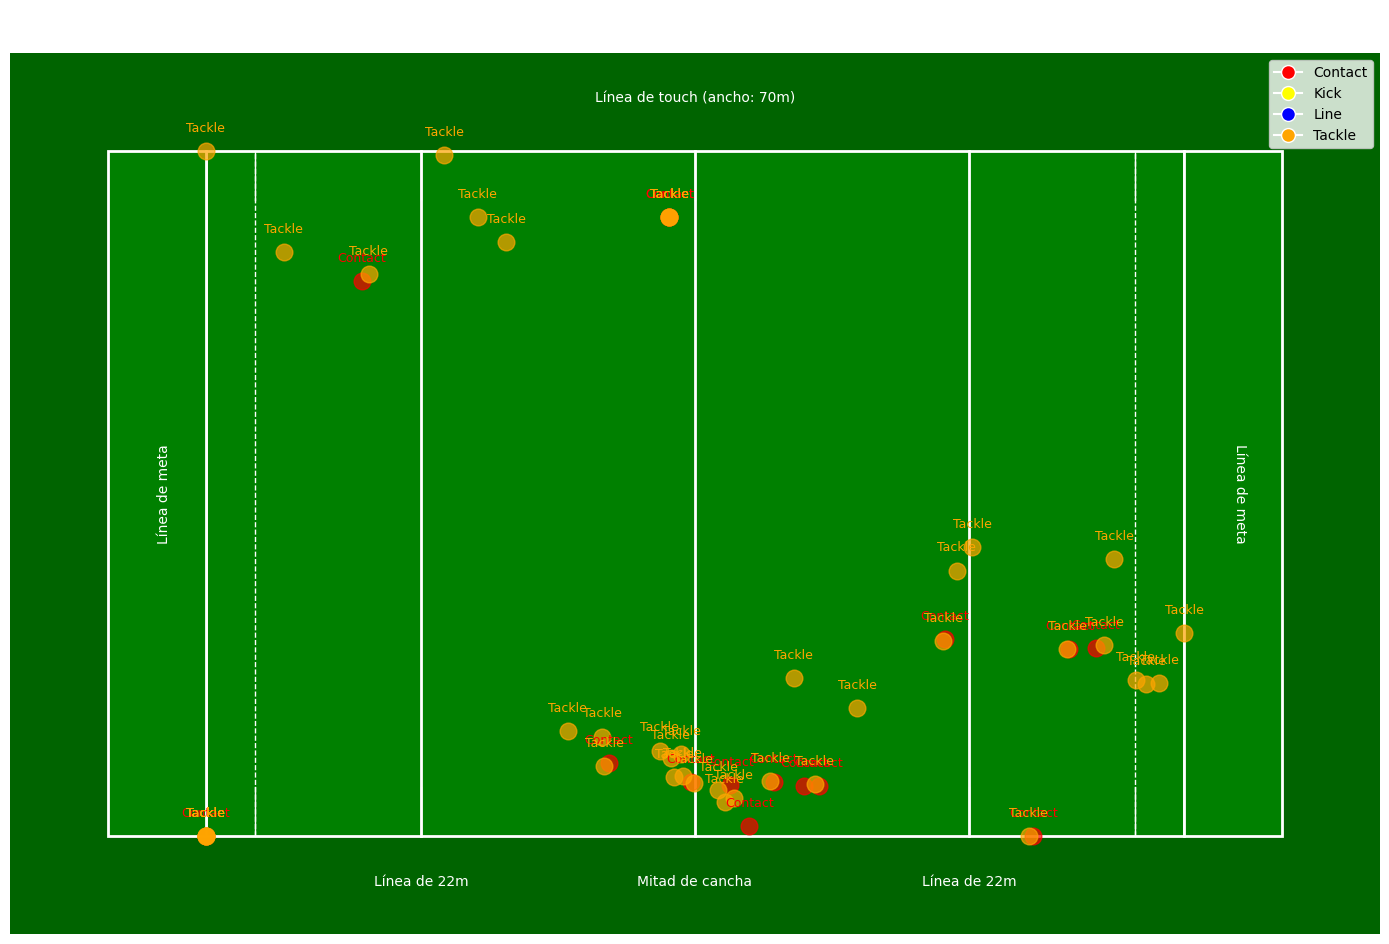

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Convertir coordenadas a metros si es necesario

# Convertir a metros (si están en milímetros)
for col in ['start_x', 'start_y', 'end_x', 'end_y']:
    df_resultado[col] = df_resultado[col].apply(lambda v: v/1000 if v > 100 else v)

# Normalizar solo los valores válidos (mayores a cero)
def normalizar_coordenadas(df, largo_campo=100, ancho_campo=70):
    df = df.copy()
    # Filtrar solo valores válidos para calcular min/max
    x_valid = df.loc[df['start_x'] > 0, 'start_x']
    y_valid = df.loc[df['start_y'] > 0, 'start_y']
    x_min = x_valid.min()
    x_max = x_valid.max()
    y_min = y_valid.min()
    y_max = y_valid.max()
    # Normalizar X
    df.loc[df['start_x'] > 0, 'start_x'] = (df.loc[df['start_x'] > 0, 'start_x'] - x_min) / (x_max - x_min) * largo_campo
    df.loc[df['end_x'] > 0, 'end_x'] = (df.loc[df['end_x'] > 0, 'end_x'] - x_min) / (x_max - x_min) * largo_campo
    # Normalizar Y
    df.loc[df['start_y'] > 0, 'start_y'] = (df.loc[df['start_y'] > 0, 'start_y'] - y_min) / (y_max - y_min) * ancho_campo
    df.loc[df['end_y'] > 0, 'end_y'] = (df.loc[df['end_y'] > 0, 'end_y'] - y_min) / (y_max - y_min) * ancho_campo
    return df




def dibujar_cancha_rugby_con_eventos(df_eventos):
    # Configuración inicial
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_aspect('equal')
    
    # Dimensiones estándar (en metros)
    ancho_total = 70
    largo_total = 100
    area_gol = 10
    linea_22 = 22
    arco_alto = 5
    
    arco_ancho = 5.6
    
    # Límites y fondo
    ax.set_xlim(-area_gol - 10, largo_total + area_gol + 10)
    ax.set_ylim(-10, ancho_total + 10)
    ax.set_axis_off()
    fondo = patches.Rectangle((-area_gol - 10, -10), largo_total + 2*area_gol + 20, ancho_total + 20, facecolor='darkgreen', zorder=0)
    ax.add_patch(fondo)
    campo_principal = patches.Rectangle((0, 0), largo_total, ancho_total, linewidth=2, edgecolor='white', facecolor='green', zorder=1)
    ax.add_patch(campo_principal)
    area_gol_izq = patches.Rectangle((-area_gol, 0), area_gol, ancho_total, linewidth=2, edgecolor='white', facecolor='green', zorder=1)
    area_gol_der = patches.Rectangle((largo_total, 0), area_gol, ancho_total, linewidth=2, edgecolor='white', facecolor='green', zorder=1)
    ax.add_patch(area_gol_izq)
    ax.add_patch(area_gol_der)
    plt.plot([largo_total/2, largo_total/2], [0, ancho_total], 'white', linewidth=2)
    plt.plot([linea_22, linea_22], [0, ancho_total], 'white', linewidth=2)
    plt.plot([largo_total-linea_22, largo_total-linea_22], [0, ancho_total], 'white', linewidth=2)
    plt.plot([5, 5], [0, ancho_total], 'white', linewidth=1, linestyle='--')
    plt.plot([largo_total-5, largo_total-5], [0, ancho_total], 'white', linewidth=1, linestyle='--')
    for x in [5, linea_22, largo_total/2, largo_total-linea_22, largo_total-5]:
        plt.plot([x, x], [0, 5], 'white', linewidth=1)
        plt.plot([x, x], [ancho_total-5, ancho_total], 'white', linewidth=1)
    # Arcos 3D omitidos por brevedad...

    # Añadir texto descriptivo
    plt.text(largo_total/2, ancho_total+5, "Línea de touch (ancho: 70m)", ha='center', color='white')
    plt.text(-5, ancho_total/2, "Línea de meta", va='center', rotation=90, color='white')
    plt.text(largo_total+5, ancho_total/2, "Línea de meta", va='center', rotation=270, color='white')
    plt.text(linea_22, -5, "Línea de 22m", ha='center', color='white')
    plt.text(largo_total-linea_22, -5, "Línea de 22m", ha='center', color='white')
    plt.text(largo_total/2, -5, "Mitad de cancha", ha='center', color='white')
    plt.title('Cancha de Rugby con Eventos', fontsize=16, pad=20, color='white')
    
    # --- Graficar eventos ---
    colores = {
        'Contact': 'red',
        'Kick': 'yellow',
        'Line': 'blue',
        'Tackle': 'orange'
    }
    for _, evento in df_eventos.iterrows():
        x = evento.get('start_x', None)
        y = evento.get('start_y', None)
        tipo = evento.get('tipo_evento', 'Evento')
        if x is not None and y is not None:
            ax.plot(x, y, 'o', color=colores.get(tipo, 'white'), markersize=12, label=tipo, alpha=0.7)
            ax.text(x, y+2, tipo, color=colores.get(tipo, 'white'), fontsize=9, ha='center')
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=tipo, markerfacecolor=col, markersize=10)
               for tipo, col in colores.items()]
    ax.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
df_normalizado = normalizar_coordenadas(df_resultado)
dibujar_cancha_rugby_con_eventos(df_normalizado)

In [10]:
import requests
import pandas as pd

API_TOKEN = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
BASE_URL = "https://connect-eu.catapultsports.com/api/v6"
activity_id = "77a7c46f-ee6b-4c90-99f2-225ed65f7d2c"

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json'
}

def obtener_atletas_por_actividad(activity_id):
    url = f"{BASE_URL}/activities/{activity_id}/athletes"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        atletas = response.json()
        print(f"✅ Se encontraron {len(atletas)} atletas en la actividad.")
        return pd.DataFrame(atletas)
    else:
        print(f"❌ Error al obtener atletas: Código {response.status_code}")
        print(response.text)
        return pd.DataFrame()

# Ejemplo de uso:
df_atletas = obtener_atletas_por_actividad(activity_id)
print(df_atletas)

✅ Se encontraron 20 atletas en la actividad.
                                      id first_name       last_name  \
0   570a25f8-2f11-4645-94d0-85333a07bf83    Facundo         Aguirre   
1   94407d60-3999-4cef-801f-40680dcfe7b0      Tomas        Anderlic   
2   e47b8285-d9c6-4b1b-907a-25d7731eba21      Lucas         Campion   
3   402e398d-58ff-40c4-9c5e-9aae1bd342f2   Bautista       Casaurang   
4   92778a7c-ea0a-437c-8ae0-b64aa9ad79f8      Pedro          Castro   
5   a74f38a5-9e37-4e73-9c92-2195730f45d4    Enrique          Devoto   
6   f96d34bc-ce28-485f-8d6b-2de8e3163492    Facundo          Fontan   
7   f4211bb7-f488-4dec-b720-839c57f21300   Benjamin       Gutierrez   
8   87448847-cb94-4548-8edd-3b610fe4288e    Esteban        Iribarne   
9   d99e65f1-c4cf-4308-b3f9-6847579b663b   Santiago          Landau   
10  e733a301-ca1e-4d6b-9dd7-f925a19a36fd   Valentin      Maztroizzi   
11  5d005fd3-faa2-47a7-bd2f-08db714b436b     Felipe        Mendonca   
12  c4a46601-e941-44c0-832a-b565

In [11]:
def resumen_back_in_game_equipo(df):
    """
    Devuelve un DataFrame con el nombre del atleta, promedio de back in game y tiempo activo por atleta,
    mostrando los valores en minutos y segundos.
    Además, imprime el promedio general del equipo en minutos y segundos.
    """
    if df is None or df.empty:
        print("No hay datos para calcular.")
        return None

    def seg_a_mmss(segundos):
        minutos = int(segundos // 60)
        segundos = int(segundos % 60)
        return f"{minutos:02d}:{segundos:02d}"

    resumen = []
    lista_promedios_seg = []
    for atleta_id in df['athlete_id'].unique():
        df_atleta = df[df['athlete_id'] == atleta_id].copy()
        nombre = df_atleta['athlete_name'].iloc[0] if 'athlete_name' in df_atleta.columns else str(atleta_id)
        df_atleta = df_atleta.sort_values('start_time').reset_index(drop=True)
        df_atleta['back_in_game'] = df_atleta['start_time'].shift(-1) - df_atleta['end_time']
        df_atleta = df_atleta.iloc[:-1]
        df_atleta = df_atleta[df_atleta['back_in_game'] >= 0]
        promedio_back = df_atleta['back_in_game'].mean() if not df_atleta.empty else 0
        tiempo_activo = df_atleta['duration'].sum() if 'duration' in df_atleta.columns else 0
        resumen.append({
            'Atleta': nombre,
            'Promedio Back in Game (mm:ss)': seg_a_mmss(promedio_back),
            'Tiempo Activo (mm:ss)': seg_a_mmss(tiempo_activo)
        })
        lista_promedios_seg.append(promedio_back)

    df_resumen = pd.DataFrame(resumen)
    promedio_equipo_seg = sum(lista_promedios_seg) / len(lista_promedios_seg) if lista_promedios_seg else 0
    print(f"\nPromedio general de Back in Game del equipo: {seg_a_mmss(promedio_equipo_seg)} (mm:ss)")
    return df_resumen

In [12]:
tipos_eventos_equipo = df_eventos_equipo_filtrado['tipo_evento'].unique()
print(tipos_eventos_equipo)

NameError: name 'df_eventos_equipo_filtrado' is not defined

In [ ]:
# ...existing code...
# DataFrame para acumular todos los eventos de todos los atletas
df_eventos_equipo = pd.DataFrame()

for idx, atleta in df_atletas.iterrows():
    atleta_id = atleta['id']
    print(f"Procesando atleta: {atleta.get('name', '')} (ID: {atleta_id})")
    df_atleta_eventos = extraer_eventos_rugby_actividad(activity_id, atleta_id)
    if df_atleta_eventos is not None and not df_atleta_eventos.empty:
        df_eventos_equipo = pd.concat([df_eventos_equipo, df_atleta_eventos], ignore_index=True)

# Filtrar eventos con confidence > 0.7 antes de guardar y calcular
df_eventos_equipo_filtrado = df_eventos_equipo[df_eventos_equipo['confidence'] > 0.7]

# Guardar todos los eventos filtrados en un solo CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_filename = f"eventos_equipo_conf70_{activity_id}_{timestamp}.csv"
df_eventos_equipo_filtrado.to_csv(csv_filename, index=False)
print(f"\n💾 Todos los eventos del equipo (confidence > 0.7) guardados en {csv_filename}")

# Ahora calcula el back in game para todo el equipo filtrado
resultado_equipo = calcular_back_in_game_equipo(df_eventos_equipo_filtrado)
print(resultado_equipo)
# ...existing code...
# ...existing code...

Procesando atleta:  (ID: 570a25f8-2f11-4645-94d0-85333a07bf83)
🔍 Extrayendo eventos de rugby para actividad: 77a7c46f-ee6b-4c90-99f2-225ed65f7d2c
🏃 Filtrando para atleta específico: 570a25f8-2f11-4645-94d0-85333a07bf83
✅ Actividad encontrada: Partido Vs Biei (ID: 77a7c46f-ee6b-4c90-99f2-225ed65f7d2c)
✅ Atleta encontrado: Nombre desconocido (ID: 570a25f8-2f11-4645-94d0-85333a07bf83)

🏃 Procesando atleta: Nombre desconocido (ID: 570a25f8-2f11-4645-94d0-85333a07bf83)
✅ Se encontraron 1 eventos para atleta Nombre desconocido

📊 Se extrajeron 55 registros de eventos en total

📊 Distribución por tipo de evento:
tipo_evento
Tackle     40
Contact    15
Name: count, dtype: int64

📊 Estadísticas básicas de campos numéricos:
         start_time      end_time   duration  confidence  evento_num  \
count  5.500000e+01  5.500000e+01  55.000000   15.000000   55.000000   
mean   1.750532e+09  1.750532e+09   2.528182    0.926800   17.090909   
std    2.154253e+03  2.154031e+03   2.550394    0.142122   1

In [ ]:
df_resumen_equipo = resumen_back_in_game_equipo(df_eventos_equipo_filtrado)
print(df_resumen_equipo)
# ...existing code...


Promedio general de Back in Game del equipo: 06:07 (mm:ss)
                   Atleta Promedio Back in Game (mm:ss) Tiempo Activo (mm:ss)
0         Facundo Aguirre                         15:39                 01:09
1          Tomas Anderlic                         08:04                 01:54
2           Lucas Campion                         05:59                 02:15
3      Bautista Casaurang                         06:16                 03:11
4            Pedro Castro                         07:05                 01:17
5          Enrique Devoto                         05:56                 04:27
6          Facundo Fontan                         04:29                 01:39
7      Benjamin Gutierrez                         10:31                 02:36
8        Esteban Iribarne                         07:34                 01:54
9         Santiago Landau                         06:16                 01:31
10    Valentin Maztroizzi                         08:27                 01:04
11  

In [ ]:
# Token API
API_TOKEN = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
BASE_URL = "https://connect-eu.catapultsports.com/api/v6"

# Configuración común para las peticiones
headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

# PASO 1: Obtener datos del sensor con manejo mejorado de errores
def obtener_datos_sensor():
    print(f"🔍 Obteniendo datos del sensor para atleta: {athlete_id}")
    
    # Configuración para probar múltiples endpoints
    endpoints = [
        f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/sensor-data",
        f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/sensor"
    ]
    
    for url in endpoints:
        try:
            print(f"📡 Intentando con endpoint: {url}")
            response = requests.get(url, headers=headers, timeout=30)
            
            print(f"📊 Código de respuesta: {response.status_code}")
            
            if response.status_code == 404:
                print(f"⚠️ No se encontraron datos con endpoint: {url}")
                continue  # Probar con el siguiente endpoint
            elif response.status_code == 403:
                print(f"❌ Error de autorización. Verifica el token API.")
                continue  # Probar con el siguiente endpoint
            elif response.status_code != 200:
                print(f"❌ Error al obtener datos: Código {response.status_code}")
                if len(response.text) < 500:
                    print(f"Respuesta: {response.text}")
                continue  # Probar con el siguiente endpoint
            
            # Procesar la respuesta exitosa
            datos_sensor = response.json()
            print(f"✅ Datos de sensor obtenidos correctamente con {url}")
            
            # Convertir a DataFrame según el formato
            if 'samples' in datos_sensor:
                # Formato 'sensor-data'
                print(f"📊 Formato 'sensor-data': {len(datos_sensor.get('samples', []))} muestras")
                if not datos_sensor['samples']:
                    print("⚠️ La lista de muestras está vacía")
                    continue  # Probar con el siguiente endpoint
                
                df_sensor = pd.DataFrame(datos_sensor['samples'])
            else:
                # Formato anterior ('sensor')
                print(f"📊 Formato 'sensor': procesando...")
                all_data = []
                
                # Puede ser una lista de atletas o un solo atleta
                datos_list = datos_sensor if isinstance(datos_sensor, list) else [datos_sensor]
                
                for athlete_data in datos_list:
                    sensor_data = athlete_data.get('data', [])
                    if not sensor_data:
                        print(f"⚠️ No hay datos de sensor para el atleta")
                        continue
                    
                    for record in sensor_data:
                        all_data.append(record)
                
                if not all_data:
                    print("⚠️ No se encontraron datos de sensor procesables")
                    continue  # Probar con el siguiente endpoint
                    
                df_sensor = pd.DataFrame(all_data)
                print(f"📊 Procesadas {len(all_data)} muestras")
            
            # Verificar si hay datos
            if df_sensor.empty:
                print("⚠️ DataFrame vacío después de procesar la respuesta")
                continue  # Probar con el siguiente endpoint
            
            # Verificar si existen las columnas necesarias
            required_columns = ['ts', 'x', 'y']
            missing_columns = [col for col in required_columns if col not in df_sensor.columns]
            if missing_columns:
                print(f"⚠️ Faltan columnas requeridas en los datos: {missing_columns}")
                print(f"Columnas disponibles: {df_sensor.columns.tolist()}")
                continue  # Probar con el siguiente endpoint
            
            # Convertir timestamp a datetime si existe
            if 'ts' in df_sensor.columns:
                df_sensor['datetime'] = pd.to_datetime(df_sensor['ts'], unit='s')
            
            # Añadir información del atleta y actividad
            df_sensor['athlete_id'] = athlete_id
            df_sensor['activity_id'] = activity_id
            
            print(f"✅ DataFrame de sensor creado con {len(df_sensor)} filas")
            return df_sensor
            
        except requests.exceptions.Timeout:
            print(f"❌ La solicitud a {url} ha excedido el tiempo de espera (timeout)")
            # Continuar con el siguiente endpoint
        except requests.exceptions.ConnectionError:
            print(f"❌ Error de conexión con {url}. Verificando otra URL...")
            # Continuar con el siguiente endpoint
        except Exception as e:
            print(f"❌ Error con {url}: {e}")
            import traceback
            traceback.print_exc()
            # Continuar con el siguiente endpoint
    
    # Si llegamos aquí, ningún endpoint funcionó
    print("❌ No se pudo obtener datos con ninguno de los endpoints probados")
    
    # Verificar la validez del token
    try:
        print("🔐 Verificando validez del token API...")
        test_url = f"{BASE_URL}/activities"
        test_response = requests.get(test_url, headers=headers)
        if test_response.status_code != 200:
            print("❌ El token API parece no ser válido o ha expirado")
        else:
            print("✅ El token API parece ser válido")
            print("❌ El problema podría estar relacionado con permisos específicos o con los IDs proporcionados")
    except Exception as e:
        print(f"❌ Error al verificar token: {e}")
    
    return None


# PASO 2: Obtener datos de eventos (sin cambios, ya funciona correctamente)
def obtener_eventos():
    print(f"🔍 Extrayendo eventos de rugby para actividad: {activity_id}")
    
    # Definir los tipos de eventos a extraer con sus etiquetas
    tipos_eventos = {
        "rugby_union_contact_involvement": "Contact",
        "rugby_union_kick": "Kick",
        "rugby_union_lineout": "Line",
        "rugby_league_tackle": "Tackle"
    }
    
    # Crear una cadena con los tipos de eventos separados por comas para la URL
    tipos_eventos_str = ",".join(tipos_eventos.keys())
    
    url = f"{BASE_URL}/activities/{activity_id}/athletes/{athlete_id}/events?event_types={tipos_eventos_str}"
    
    try:
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"❌ Error al obtener eventos: Código {response.status_code}")
            print(f"Respuesta: {response.text}")
            return None
        
        eventos = response.json()
        
        if not eventos or len(eventos) == 0:
            print("❌ No se encontraron eventos para este atleta")
            return None
        
        print(f"✅ Se encontraron {len(eventos)} eventos para el atleta")
        
        # Lista para almacenar todos los registros de eventos procesados
        todos_registros = []
        
        # Procesar cada evento
        for evento in eventos:
            # Extraer data y verificar si es string
            data = evento.get('data', {})
            if isinstance(data, str):
                try:
                    data = json.loads(data)
                except:
                    continue
            
            # Información básica del evento
            info_basica = {
                'activity_id': activity_id,
                'athlete_id': evento.get('athlete_id'),
                'athlete_name': f"{evento.get('athlete_first_name', '')} {evento.get('athlete_last_name', '')}".strip(),
                'team_name': evento.get('team_name', ''),
                'jersey': evento.get('jersey', '')
            }
            
            # Procesar cada tipo de evento si está presente en data
            for tipo_evento, etiqueta in tipos_eventos.items():
                if tipo_evento in data:
                    # Puede ser una lista o un objeto único
                    eventos_especificos = data[tipo_evento]
                    
                    # Si no es una lista, convertirlo a lista para procesamiento uniforme
                    if not isinstance(eventos_especificos, list):
                        eventos_especificos = [eventos_especificos]
                    
                    # Para cada evento específico
                    for evento_especifico in eventos_especificos:
                        # Crear un nuevo registro con la información base
                        registro = info_basica.copy()
                        
                        # Añadir datos específicos del evento
                        registro['start_time'] = evento_especifico.get('start_time')
                        registro['end_time'] = evento_especifico.get('end_time')
                        registro['tipo_evento'] = etiqueta
                        registro['confidence'] = evento_especifico.get('confidence')
                        
                        # Convertir timestamps a datetime
                        if registro['start_time']:
                            registro['start_time_dt'] = pd.to_datetime(registro['start_time'], unit='s')
                        if registro['end_time']:
                            registro['end_time_dt'] = pd.to_datetime(registro['end_time'], unit='s')
                        
                        # Añadir este registro a nuestra lista
                        todos_registros.append(registro)
        
        # Crear DataFrame con todos los registros procesados
        if todos_registros:
            df_eventos = pd.DataFrame(todos_registros)
            return df_eventos
        else:
            print("❌ No se encontraron registros de eventos procesables")
            return None
            
    except Exception as e:
        print(f"❌ Error al obtener eventos: {e}")
        import traceback
        traceback.print_exc()
        return None

# PASO 3: Fusionar ambos DataFrames
def fusionar_datos():
    # Obtener los datos
    df_sensor = obtener_datos_sensor()
    
    if df_sensor is None:
        print("❌ No se pudieron obtener datos de sensores. Por favor, verifica la API o la conexión.")
        return None
        
    df_eventos = obtener_eventos()
    
    if df_eventos is None:
        print("❌ No se pudieron obtener datos de eventos.")
        return None
    
    print("\n🔄 Fusionando datos de sensores y eventos...")
    
    # Lista para almacenar eventos enriquecidos
    eventos_enriquecidos = []
    
    # Para cada evento, encontrar la medición de sensor más cercana
    for _, evento in df_eventos.iterrows():
        start_time = evento['start_time']
        end_time = evento['end_time']
        
        # Buscar medición más cercana al inicio del evento
        df_sensor['diff_start'] = abs(df_sensor['ts'] - start_time)
        idx_start = df_sensor['diff_start'].idxmin()
        coords_start = df_sensor.loc[idx_start]
        
        # Buscar medición más cercana al final del evento
        df_sensor['diff_end'] = abs(df_sensor['ts'] - end_time)
        idx_end = df_sensor['diff_end'].idxmin()
        coords_end = df_sensor.loc[idx_end]
        
        # Crear copia del evento y añadir coordenadas
        evento_enriquecido = evento.copy()
        
        # Coordenadas al inicio del evento
        evento_enriquecido['start_x'] = coords_start.get('x', None)
        evento_enriquecido['start_y'] = coords_start.get('y', None)
        evento_enriquecido['start_ts'] = coords_start.get('ts', None)
        # Coordenadas al final del evento
        evento_enriquecido['end_x'] = coords_end.get('x', None)
        evento_enriquecido['end_y'] = coords_end.get('y', None)
        evento_enriquecido['end_ts'] = coords_end.get('ts', None)
        # Añadir evento enriquecido a la lista
        eventos_enriquecidos.append(evento_enriquecido)
    
    # Crear DataFrame con eventos enriquecidos
    df_final = pd.DataFrame(eventos_enriquecidos)
    
    print(f"✅ Se enriquecieron {len(df_final)} eventos con coordenadas")
    
    # Guardar resultados en CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_filename = f"eventos_coord_{activity_id}_{athlete_id}_{timestamp}.csv"
    df_final.to_csv(csv_filename, index=False)
    print(f"💾 Resultados guardados en {csv_filename}")
    
    return df_final

# Ejecutar la fusión
df_resultado = fusionar_datos()

# Mostrar las primeras filas del resultado
if df_resultado is not None:
    print("\n📊 Primeras filas del DataFrame final:")
    print(df_resultado.head())
else:
    print("\n❌ No se pudo completar la fusión de datos. Por favor, verifica los problemas anteriores.")
    
    
    


activity_id = "77a7c46f-ee6b-4c90-99f2-225ed65f7d2c"

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json'
}

def obtener_atletas_por_actividad(activity_id):
    url = f"{BASE_URL}/activities/{activity_id}/athletes"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        atletas = response.json()
        print(f"✅ Se encontraron {len(atletas)} atletas en la actividad.")
        return pd.DataFrame(atletas)
    else:
        print(f"❌ Error al obtener atletas: Código {response.status_code}")
        print(response.text)
        return pd.DataFrame()


def resumen_back_in_game_equipo(df):
    """
    Devuelve un DataFrame con el nombre del atleta, promedio de back in game y tiempo activo por atleta,
    mostrando los valores en minutos y segundos.
    Además, imprime el promedio general del equipo en minutos y segundos.
    """
    if df is None or df.empty:
        print("No hay datos para calcular.")
        return None

    def seg_a_mmss(segundos):
        minutos = int(segundos // 60)
        segundos = int(segundos % 60)
        return f"{minutos:02d}:{segundos:02d}"

    resumen = []
    lista_promedios_seg = []
    for atleta_id in df['athlete_id'].unique():
        df_atleta = df[df['athlete_id'] == atleta_id].copy()
        nombre = df_atleta['athlete_name'].iloc[0] if 'athlete_name' in df_atleta.columns else str(atleta_id)
        df_atleta = df_atleta.sort_values('start_time').reset_index(drop=True)
        df_atleta['back_in_game'] = df_atleta['start_time'].shift(-1) - df_atleta['end_time']
        df_atleta = df_atleta.iloc[:-1]
        df_atleta = df_atleta[df_atleta['back_in_game'] >= 0]
        promedio_back = df_atleta['back_in_game'].mean() if not df_atleta.empty else 0
        tiempo_activo = df_atleta['duration'].sum() if 'duration' in df_atleta.columns else 0
        resumen.append({
            'Atleta': nombre,
            'Promedio Back in Game (mm:ss)': seg_a_mmss(promedio_back),
            'Tiempo Activo (mm:ss)': seg_a_mmss(tiempo_activo)
        })
        lista_promedios_seg.append(promedio_back)

    df_resumen = pd.DataFrame(resumen)
    promedio_equipo_seg = sum(lista_promedios_seg) / len(lista_promedios_seg) if lista_promedios_seg else 0
    print(f"\nPromedio general de Back in Game del equipo: {seg_a_mmss(promedio_equipo_seg)} (mm:ss)")
    return df_resumen


df_resumen_equipo = resumen_back_in_game_equipo(df_eventos_equipo_filtrado)
print(df_resumen_equipo)

🔍 Obteniendo datos del sensor para atleta: 570a25f8-2f11-4645-94d0-85333a07bf83
📡 Intentando con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor-data
📊 Código de respuesta: 404
⚠️ No se encontraron datos con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor-data
📡 Intentando con endpoint: https://connect-eu.catapultsports.com/api/v6/activities/77a7c46f-ee6b-4c90-99f2-225ed65f7d2c/athletes/570a25f8-2f11-4645-94d0-85333a07bf83/sensor


KeyboardInterrupt: 

In [ ]:
import requests
import pandas as pd
import json
from datetime import datetime

# Configuración API
API_TOKEN = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
BASE_URL = "https://connect-eu.catapultsports.com/api/v6"
activity_id = "77a7c46f-ee6b-4c90-99f2-225ed65f7d2c"

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json'
}

# Función para obtener atletas de la actividad
def obtener_atletas_por_actividad(activity_id):
    url = f"{BASE_URL}/activities/{activity_id}/athletes"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        atletas = response.json()
        print(f"✅ Se encontraron {len(atletas)} atletas en la actividad.")
        return pd.DataFrame(atletas)
    else:
        print(f"❌ Error al obtener atletas: Código {response.status_code}")
        print(response.text)
        return pd.DataFrame()

# Función para extraer eventos de rugby para un atleta
def extraer_eventos_rugby_actividad(activity_id, athlete_id=None):
    import time
    BASE_URL = "https://connect-eu.catapultsports.com/api/v6"
    API_KEY = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjEzMWY5NGIxOTg3ZGY4NzcxNTljOGQ2MTAzMTIzNDNjIn0.eyJhdWQiOiI0NjFiMTExMS02ZjdhLTRkYmItOWQyOS0yMzAzOWZlMjI4OGUiLCJqdGkiOiIyZWRiNmEzMWE4YmQzMTlkZjgxYWYwZDAxYmYyN2NlYTIxMjM2YzQzMzk0NjE2Y2YyMTkzMDc0NzM3YWQ5NjQzODljODc4YTJiOGNjMjRlOCIsImlhdCI6MTc0ODUyNDYyMC42Mzk4NDIsIm5iZiI6MTc0ODUyNDYyMC42Mzk4NDQsImV4cCI6NDkwMjEyNDYyMC42MzE1MjYsInN1YiI6IjRhMTQyMzAwLWQ1NmUtNDg3ZC1iOWVlLThmN2Q2MWUyODJhZSIsInNjb3BlcyI6WyJjb25uZWN0Iiwic2Vuc29yLXJlYWQtb25seSJdLCJpc3MiOiJodHRwczovL2JhY2tlbmQtZXUub3BlbmZpZWxkLmNhdGFwdWx0c3BvcnRzLmNvbSIsImNvbS5jYXRhcHVsdHNwb3J0cyI6eyJvcGVuZmllbGQiOnsiY3VzdG9tZXJzIjpbeyJyZWxhdGlvbiI6ImF1dGgiLCJpZCI6NDA4fV19fX0.FYqss4dsTD3zTt6U9dLyxG-W1EauM76gG0s4AohsUlsA_Pq7ZkgUHxSLKnmJY3a0QorATwEY8XR-hRzBu_MU_2pwC3aibqPo6ngRT0rM5aaJiKypRSB9JtGCPROHtKvK23aHSDn2kB_snU0vyvSCp-o82c4XEfM0ZKNNPx15DDxt1ofn_2HwsDlrEQo5JNSY9kwoSh7BTeUHrGe-2jwWPBe3SKQweR_spWiCAJdb1GciZs5U9JaDh_YLmXEhk4Ks7Pr5_NRAvBaIyXN_HD0CwvMHQ_TdgWCEq7CCUEZJWrX6Qw5HX720S9ZYKmFXjR1bxEKt7YEI8Qmi3sFPMoQqMU24DJznRHNT1Maz4aJZWECSvgK6PcDqn6XxqhwtIdvFcVKAH4HFJZoUbV95hwy1ZkO7Q4pq3GKi1DWweXNG-KJxakLlzQpIXZuUUPl68sKnMRzKNHSpMZp_AQ8s9M0hG4jBuPUC_UFMH7PJBhwrugRIWU2dCLqNO1xK9MZjt5dHXXr93IsoP2pDAnFJoPc5mqQJW1AJJ2bzkECW9TfDsA79uAXLHImBnYfcSevabnth2SOlM9602kLst5yP6wEKyOxUl26TJjgXXs8qE2nwh9uj_Jy4EhuVqPxHPJyRHmB0My_Uilt3rIZbeIg_-upSBbn-7aPLH2i_GiKF7iHkIbk'
    headers = {
        'Authorization': f'Bearer {API_KEY}',
        'Content-Type': 'application/json'
    }
    url_atletas = f"{BASE_URL}/activities/{activity_id}/athletes"
    try:
        resp_atletas = requests.get(url_atletas, headers=headers, timeout=15)
        if resp_atletas.status_code != 200:
            print(f"❌ Error al obtener atletas: {resp_atletas.status_code}")
            return pd.DataFrame()
        atletas = resp_atletas.json()
        if athlete_id:
            atletas = [ath for ath in atletas if ath['id'] == athlete_id]
            if not atletas:
                print(f"❌ Atleta con ID {athlete_id} no encontrado en la actividad")
                return pd.DataFrame()
        todos_registros = []
        total = len(atletas)
        for idx, atleta in enumerate(atletas):
            aid = atleta['id']
            nombre = atleta.get('name', '')
            print(f"Procesando atleta {idx+1}/{total}: {nombre} (ID: {aid})")
            url = f"{BASE_URL}/activities/{activity_id}/athletes/{aid}/events"
            try:
                response = requests.get(url, headers=headers, timeout=20)
                if response.status_code != 200:
                    print(f"❌ Error al obtener eventos para atleta {aid}: {response.status_code}")
                    continue
                eventos = response.json()
                if not eventos:
                    print(f"ℹ️ No se encontraron eventos para atleta {aid}")
                    continue
                for evento in eventos:
                    registro = {
                        'activity_id': activity_id,
                        'athlete_id': evento.get('athlete_id', aid),
                        'athlete_name': f"{evento.get('athlete_first_name', '')} {evento.get('athlete_last_name', '')}".strip(),
                        'team_name': evento.get('team_name', ''),
                        'jersey': evento.get('jersey', ''),
                        'tipo_evento': evento.get('event_type', ''),
                        'start_time': evento.get('start_time'),
                        'end_time': evento.get('end_time'),
                        'confidence': evento.get('confidence'),
                        'data': evento.get('data')
                    }
                    todos_registros.append(registro)
            except requests.exceptions.Timeout:
                print(f"⏰ Timeout al obtener eventos para atleta {aid}")
            except Exception as e:
                print(f"❌ Error inesperado para atleta {aid}: {e}")
            time.sleep(0.2)  # Pequeña pausa para no saturar la API
        if todos_registros:
            return pd.DataFrame(todos_registros)
        else:
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error general: {e}")
        return pd.DataFrame()

# Función para calcular resumen de back in game por atleta y equipo
def resumen_back_in_game_equipo(df):
    if df is None or df.empty:
        print("No hay datos para calcular.")
        return None
    def seg_a_mmss(segundos):
        minutos = int(segundos // 60)
        segundos = int(segundos % 60)
        return f"{minutos:02d}:{segundos:02d}"
    resumen = []
    lista_promedios_seg = []
    for atleta_id in df['athlete_id'].unique():
        df_atleta = df[df['athlete_id'] == atleta_id].copy()
        nombre = df_atleta['athlete_name'].iloc[0] if 'athlete_name' in df_atleta.columns else str(atleta_id)
        df_atleta = df_atleta.sort_values('start_time').reset_index(drop=True)
        df_atleta['back_in_game'] = df_atleta['start_time'].shift(-1) - df_atleta['end_time']
        df_atleta = df_atleta.iloc[:-1]
        df_atleta = df_atleta[df_atleta['back_in_game'] >= 0]
        promedio_back = df_atleta['back_in_game'].mean() if not df_atleta.empty else 0
        tiempo_activo = df_atleta['duration'].sum() if 'duration' in df_atleta.columns else 0
        resumen.append({
            'Atleta': nombre,
            'Promedio Back in Game (mm:ss)': seg_a_mmss(promedio_back),
            'Tiempo Activo (mm:ss)': seg_a_mmss(tiempo_activo)
        })
        lista_promedios_seg.append(promedio_back)
    df_resumen = pd.DataFrame(resumen)
    promedio_equipo_seg = sum(lista_promedios_seg) / len(lista_promedios_seg) if lista_promedios_seg else 0
    print(f"\nPromedio general de Back in Game del equipo: {seg_a_mmss(promedio_equipo_seg)} (mm:ss)")
    return df_resumen

# --- PROCESO PRINCIPAL ---
df_atletas = obtener_atletas_por_actividad(activity_id)
df_eventos_equipo = pd.DataFrame()
for idx, atleta in df_atletas.iterrows():
    atleta_id = atleta['id']
    print(f"Procesando atleta: {atleta.get('name', '')} (ID: {atleta_id})")
    df_atleta_eventos = extraer_eventos_rugby_actividad(activity_id, atleta_id)
    if df_atleta_eventos is not None and not df_atleta_eventos.empty:
        df_eventos_equipo = pd.concat([df_eventos_equipo, df_atleta_eventos], ignore_index=True)

# Filtrar eventos con confidence > 0.7
df_eventos_equipo_filtrado = df_eventos_equipo[df_eventos_equipo['confidence'] > 0.7]

# Guardar todos los eventos filtrados en un solo CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_filename = f"eventos_equipo_conf70_{activity_id}_{timestamp}.csv"
df_eventos_equipo_filtrado.to_csv(csv_filename, index=False)
print(f"\n💾 Todos los eventos del equipo (confidence > 0.7) guardados en {csv_filename}")

# Mostrar los tipos de eventos presentes
tipos_eventos_equipo = df_eventos_equipo_filtrado['tipo_evento'].unique()
print("Tipos de eventos presentes en el equipo:", tipos_eventos_equipo)

# Calcular y mostrar el resumen de back in game por atleta y promedio del equipo
df_resumen_equipo = resumen_back_in_game_equipo(df_eventos_equipo_filtrado)
print("\nResumen Back in Game por atleta:")
print(df_resumen_equipo)

KeyboardInterrupt: 

In [ ]:
df_eventos_equipo_filtrado = df_resultado[df_resultado['tipo_evento'].isin(['Contact', 'Kick', 'Line', 'Tackle'])]
print("\nEventos filtrados por tipo de evento:")


Eventos filtrados por tipo de evento:


In [ ]:
tipos_eventos_equipo

array(['Contact', 'Kick'], dtype=object)

In [ ]:
df_resumen_equipo

,Atleta,Promedio Back in Game (mm:ss),Tiempo Activo (mm:ss)
0,Facundo Aguirre,15:39,01:09
1,Tomas Anderlic,08:04,01:54
2,Lucas Campion,05:59,02:15
3,Bautista Casaurang,06:16,03:11
4,Pedro Castro,07:05,01:17
5,Enrique Devoto,05:56,04:27
6,Facundo Fontan,04:29,01:39
7,Benjamin Gutierrez,10:31,02:36
8,Esteban Iribarne,07:34,01:54
9,Santiago Landau,06:16,01:31
